<a href="https://colab.research.google.com/github/Ronikghale/News-Classification/blob/main/News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [ ]:
df

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,0
119996,Renteria signing a top-shelf deal Red Sox gene...,1
119997,Saban not going to Dolphins yet The Miami Dolp...,1
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)

from wordcloud import WordCloud
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)



In [ ]:
dataset = load_dataset("ag_news")

df = pd.DataFrame(dataset["train"])
X = df["text"]
y = df["label"]


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [ ]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

In [ ]:
y_pred = lr_model.predict(X_test_tfidf)
y_prob = lr_model.predict_proba(X_test_tfidf)


In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="weighted"))
print("Recall:", recall_score(y_test, y_pred, average="weighted"))
print("F1-score:", f1_score(y_test, y_pred, average="weighted"))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.91025
Precision: 0.9100051898251654
Recall: 0.91025
F1-score: 0.9100664711121884

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      6000
           1       0.95      0.97      0.96      6000
           2       0.88      0.88      0.88      6000
           3       0.89      0.89      0.89      6000

    accuracy                           0.91     24000
   macro avg       0.91      0.91      0.91     24000
weighted avg       0.91      0.91      0.91     24000



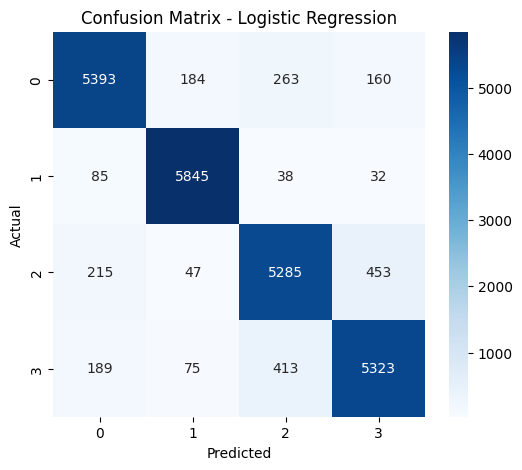

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


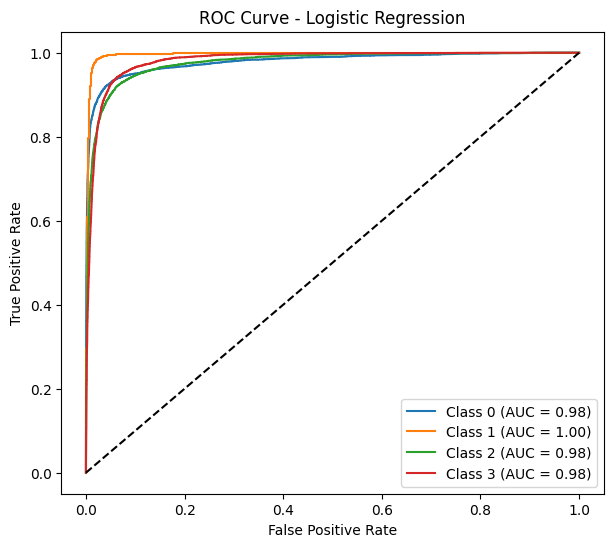

In [ ]:
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=[0,1,2,3])

plt.figure(figsize=(7,6))

for i in range(4):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


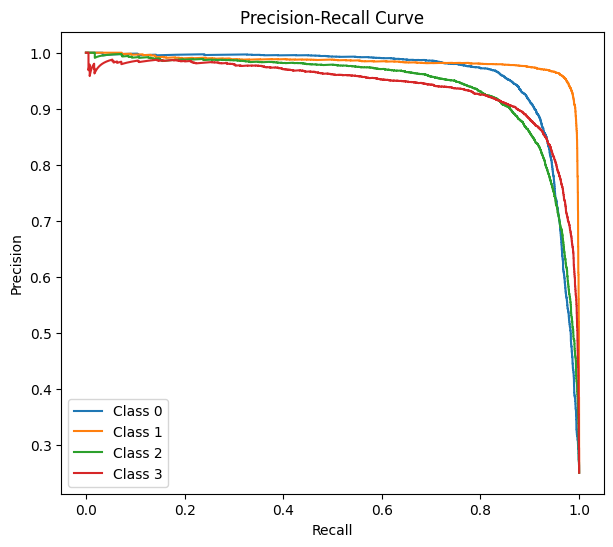

In [ ]:
plt.figure(figsize=(7,6))

for i in range(4):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


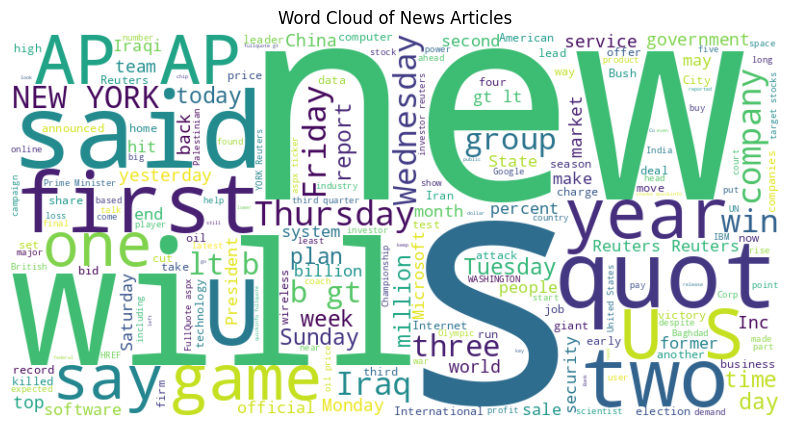

In [ ]:
wordcloud = WordCloud(
    width=800, height=400,
    background_color="white"
).generate(" ".join(X_train[:2000]))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of News Articles")
plt.show()


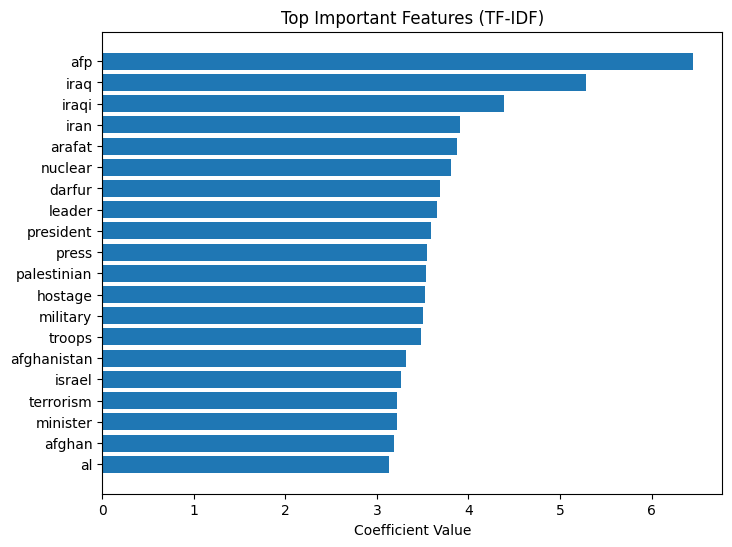

In [ ]:
feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

top_features = np.argsort(coefficients)[-20:]

plt.figure(figsize=(8,6))
plt.barh(
    [feature_names[i] for i in top_features],
    coefficients[top_features]
)
plt.title("Top Important Features (TF-IDF)")
plt.xlabel("Coefficient Value")
plt.show()


In [ ]:
label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

sample_texts = X_test[:5]

sample_vec = tfidf.transform(sample_texts)
predictions = lr_model.predict(sample_vec)

for text, pred in zip(sample_texts, predictions):
    print("\nText:", text[:200], "...")
    print("Predicted Category:", label_map[pred])



Text: Wall Street's Designs on '05? A Merger Boom After years of self-doubt and housecleaning in the wake of Enron, corporate America has gotten a bit of swagger back in its step. ...
Predicted Category: Business

Text: Dodgers sign Ledee to two-year deal The Los Angeles Dodgers signed Ricky Ledee to a two-year contract Monday, giving them a left-handed pinch-hitter and more depth in the outfield. ...
Predicted Category: Sports

Text: Olympians pursuit of marketing gold begins long before medals &lt;b&gt;...&lt;/b&gt; For millions of Americans, gymnast Paul Hamm #39;s fame began only when the broad-shouldered Olympian shrugged off  ...
Predicted Category: Sports

Text: New Device: Flying Robot Seiko Epson hopes the tiny robot will help in security, disaster and rescue and space exploration. Also: Apple recalls batteries from its 15-inch PowerBook G4 laptops   hellip ...
Predicted Category: Sci/Tech

Text: Spanish laureate 'was informer' Prize-winning Spanish writer  Camilo Jose Cela i

In [ ]:
!pip install datasets transformers accelerate scikit-learn torch


In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize


In [ ]:
dataset = load_dataset("ag_news")

train_texts = dataset["train"]["text"]
train_labels = dataset["train"]["label"]

test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128
    )

train_encodings = tokenize_data(list(train_texts))
test_encodings = tokenize_data(list(test_texts))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)


In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="no"
)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
from transformers import TrainingArguments


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="no",
    report_to="none"
)


In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.190700,0.179017,0.945000,0.945090,0.945000,0.944996
2,0.120700,0.190064,0.947763,0.947933,0.947763,0.947798


TrainOutput(global_step=15000, training_loss=0.1771327163696289, metrics={'train_runtime': 5346.2633, 'train_samples_per_second': 44.891, 'train_steps_per_second': 2.806, 'total_flos': 1.578694680576e+16, 'train_loss': 0.1771327163696289, 'epoch': 2.0})

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)


{'eval_loss': 0.19006356596946716, 'eval_accuracy': 0.9477631578947369, 'eval_precision': 0.9479326207759747, 'eval_recall': 0.9477631578947369, 'eval_f1': 0.9477978213936585, 'eval_runtime': 56.8734, 'eval_samples_per_second': 133.63, 'eval_steps_per_second': 8.352, 'epoch': 2.0}


In [ ]:
globals().keys()


In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_dataset = tokenized_datasets["train"]
tokenized_test_dataset = tokenized_datasets["test"]


In [ ]:
import numpy as np

predictions = trainer.predict(tokenized_test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids


In [ ]:
from sklearn.metrics import classification_report

target_names = ["World", "Sports", "Business", "Sci/Tech"]

print(classification_report(
    y_true,
    y_pred,
    target_names=target_names
))


              precision    recall  f1-score   support

       World       0.96      0.96      0.96      1900
      Sports       0.99      0.99      0.99      1900
    Business       0.93      0.91      0.92      1900
    Sci/Tech       0.91      0.94      0.92      1900

    accuracy                           0.95      7600
   macro avg       0.95      0.95      0.95      7600
weighted avg       0.95      0.95      0.95      7600



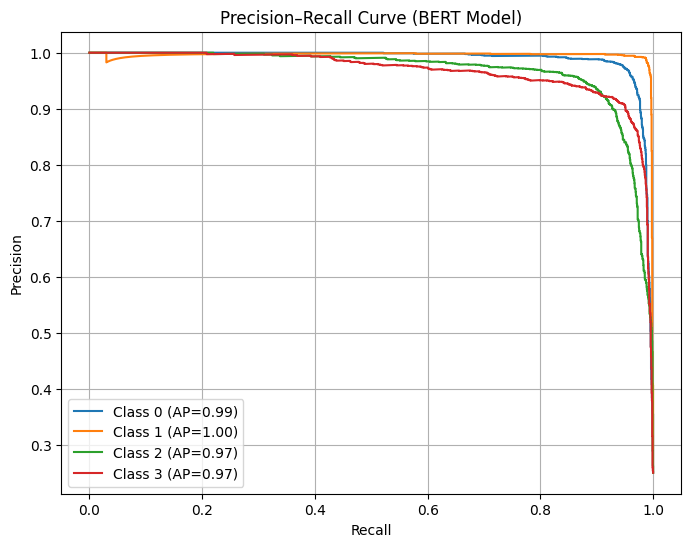

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

n_classes = len(set(y_true))

# Binarize labels
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
y_score = predictions.predictions

plt.figure(figsize=(8,6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(
        y_true_bin[:, i],
        y_score[:, i]
    )
    ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f'Class {i} (AP={ap:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (BERT Model)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
original_test_dataset = dataset["test"]

label_names = ["World", "Sports", "Business", "Sci/Tech"]

for i in range(3):
    print("Text:", original_test_dataset[i]["text"][:300])
    print("Actual:", label_names[y_true[i]])
    print("Predicted:", label_names[y_pred[i]])
    print("-" * 60)


Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
Actual: Business
Predicted: Business
------------------------------------------------------------
Text: The Race is On: Second Private Team Sets Launch Date for Human Spaceflight (SPACE.com) SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date f
Actual: Sci/Tech
Predicted: Sci/Tech
------------------------------------------------------------
Text: Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.
Actual: Sci/Tech
Predicted: Sci/Tech
-------------------------

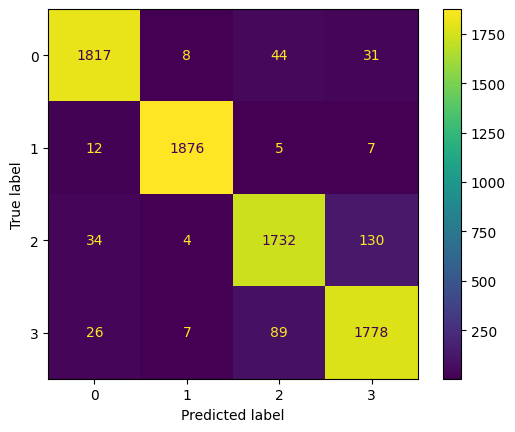

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

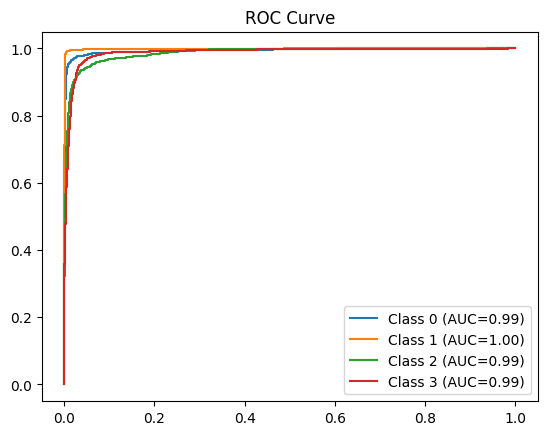

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve

n_classes = len(set(y_true))
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

y_score = predictions.predictions

# ROC Curve
plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC={roc_auc:.2f})')

plt.legend()
plt.title("ROC Curve")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Logistic Regression Metrics ---
# y_test from cell VdvLyDtm0Tmx (original split)
# X_test_tfidf from cell Ty4is5zV0ZO7
# lr_model from cell nsDj3BLG0bfl

y_true_lr = y_test
y_pred_lr = lr_model.predict(X_test_tfidf)

lr_accuracy = accuracy_score(y_true_lr, y_pred_lr)
lr_precision = precision_score(y_true_lr, y_pred_lr, average="weighted")
lr_recall = recall_score(y_true_lr, y_pred_lr, average="weighted")
lr_f1 = f1_score(y_true_lr, y_pred_lr, average="weighted")

# --- BERT Metrics ---
# y_true and y_pred are already set from cell oJx5OfpCs3TE (BERT predictions)

y_true_bert = y_true
y_pred_bert = y_pred

bert_accuracy = accuracy_score(y_true_bert, y_pred_bert)
bert_precision = precision_score(y_true_bert, y_pred_bert, average="weighted")
bert_recall = recall_score(y_true_bert, y_pred_bert, average="weighted")
bert_f1 = f1_score(y_true_bert, y_pred_bert, average="weighted")

print("Logistic Regression Metrics:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-score: {lr_f1:.4f}")

print("\nBERT Metrics:")
print(f"Accuracy: {bert_accuracy:.4f}")
print(f"Precision: {bert_precision:.4f}")
print(f"Recall: {bert_recall:.4f}")
print(f"F1-score: {bert_f1:.4f}")

Logistic Regression Metrics:
Accuracy: 0.9103
Precision: 0.9100
Recall: 0.9103
F1-score: 0.9101

BERT Metrics:
Accuracy: 0.9478
Precision: 0.9479
Recall: 0.9478
F1-score: 0.9478


In [ ]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "BERT"],
    "Accuracy": [lr_accuracy, bert_accuracy],
    "Precision": [lr_precision, bert_precision],
    "Recall": [lr_recall, bert_recall],
    "F1-Score": [lr_f1, bert_f1]
})

comparison_df.round(4)


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.9102,0.9100,0.9102,0.9101
1,BERT,0.9478,0.9479,0.9478,0.9478


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Recall', y='F1-Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy'}, axis=1)
              .sort_values('Accuracy', ascending=True))
  xs = counted['Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Precision']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Precision'}, axis=1)
              .sort_values('Precision', ascending=True))
  xs = counted['Precision']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Precision', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Precision')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Recall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Recall'}, axis=1)
              .sort_values('Recall', ascending=True))
  xs = counted['Recall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('Recall', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Precision', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='Recall', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)